In [1]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [2]:
import sys
sys.path.append("../libs/")

import numpy as np
import torch
import torch.nn as nn
from train_utils import FeatureQuantization
from math_utils import do_kmeans, assign_to_nearest_anchor
from visualize import StackedFeatureGrapher
import json
from keplergl import KeplerGl

# Searching similar area

You can select a specific mesh and use the similarity from its embedding to search for similar meshes. Here, you weight the areas according to their distance from the specific mesh, group them, and visually represent them on a geographical map.

In [3]:
data_name = "2021"
state_dict = torch.load("../data/japan_city/model/"+data_name+".pth")
with open("../data/japan_city/geojson/"+data_name+".geojson", "r") as f:
    mesh_data = json.load(f)
embeddings = torch.tensor([mesh["properties"]["vector"] for mesh in mesh_data["features"]])
_, decoder = state_dict["embedding.weight"], state_dict["decode_linear.weight"]
softmax = nn.Softmax(dim = 1)
stay_weight_matrix = np.load("../data/util_file/stay_weight_matrix.npy")

In [4]:
dist_bins = [2.0, 4.0, 8.0, 16.0]#Divide into several bins based on distance.
target_mid = 52793

# Retrieve the center vector
center_vector = embeddings[target_mid]

# Calculate the distance from each vector to the center vector
distances = np.linalg.norm(embeddings - center_vector, axis=1)
result = np.zeros(len(embeddings), dtype=int) + 1
result[target_mid] = 0

# Classify vectors based on distance bins
for i, bin_edge in enumerate(dist_bins):
    result[(distances > bin_edge)] = i + 2
result[distances >= dist_bins[-1]] = len(dist_bins) + 1

## Visualize approximated area usage pattens each cluster.

By applying the model's decoder weights to the embeddings, we can approximate the distribution of area features. The approximated feature distributions are visualized using stacked bar graphs, allowing for the analysis of usage trends in each cluster.

In [5]:
approximation_stats = softmax(torch.matmul(embeddings, decoder.T))
stay_each_mesh_dow_dt_e =approximation_stats.numpy().dot(stay_weight_matrix).reshape(embeddings.shape[0], 2, 12, 7)
stay_each_mesh_dow_e_dt =np.transpose(stay_each_mesh_dow_dt_e, (0, 1, 3, 2))
visualizer = StackedFeatureGrapher(FeatureQuantization(), day_counts = [22,8])
visualizer.aggregate_data_from_approximated_features(stay_each_mesh_dow_e_dt, result, sort=False)

/Users/tamuranaoki/Documents/workspace/my_paper/anchoring/code/0503/openuas/src/../libs/visualize.py:141: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


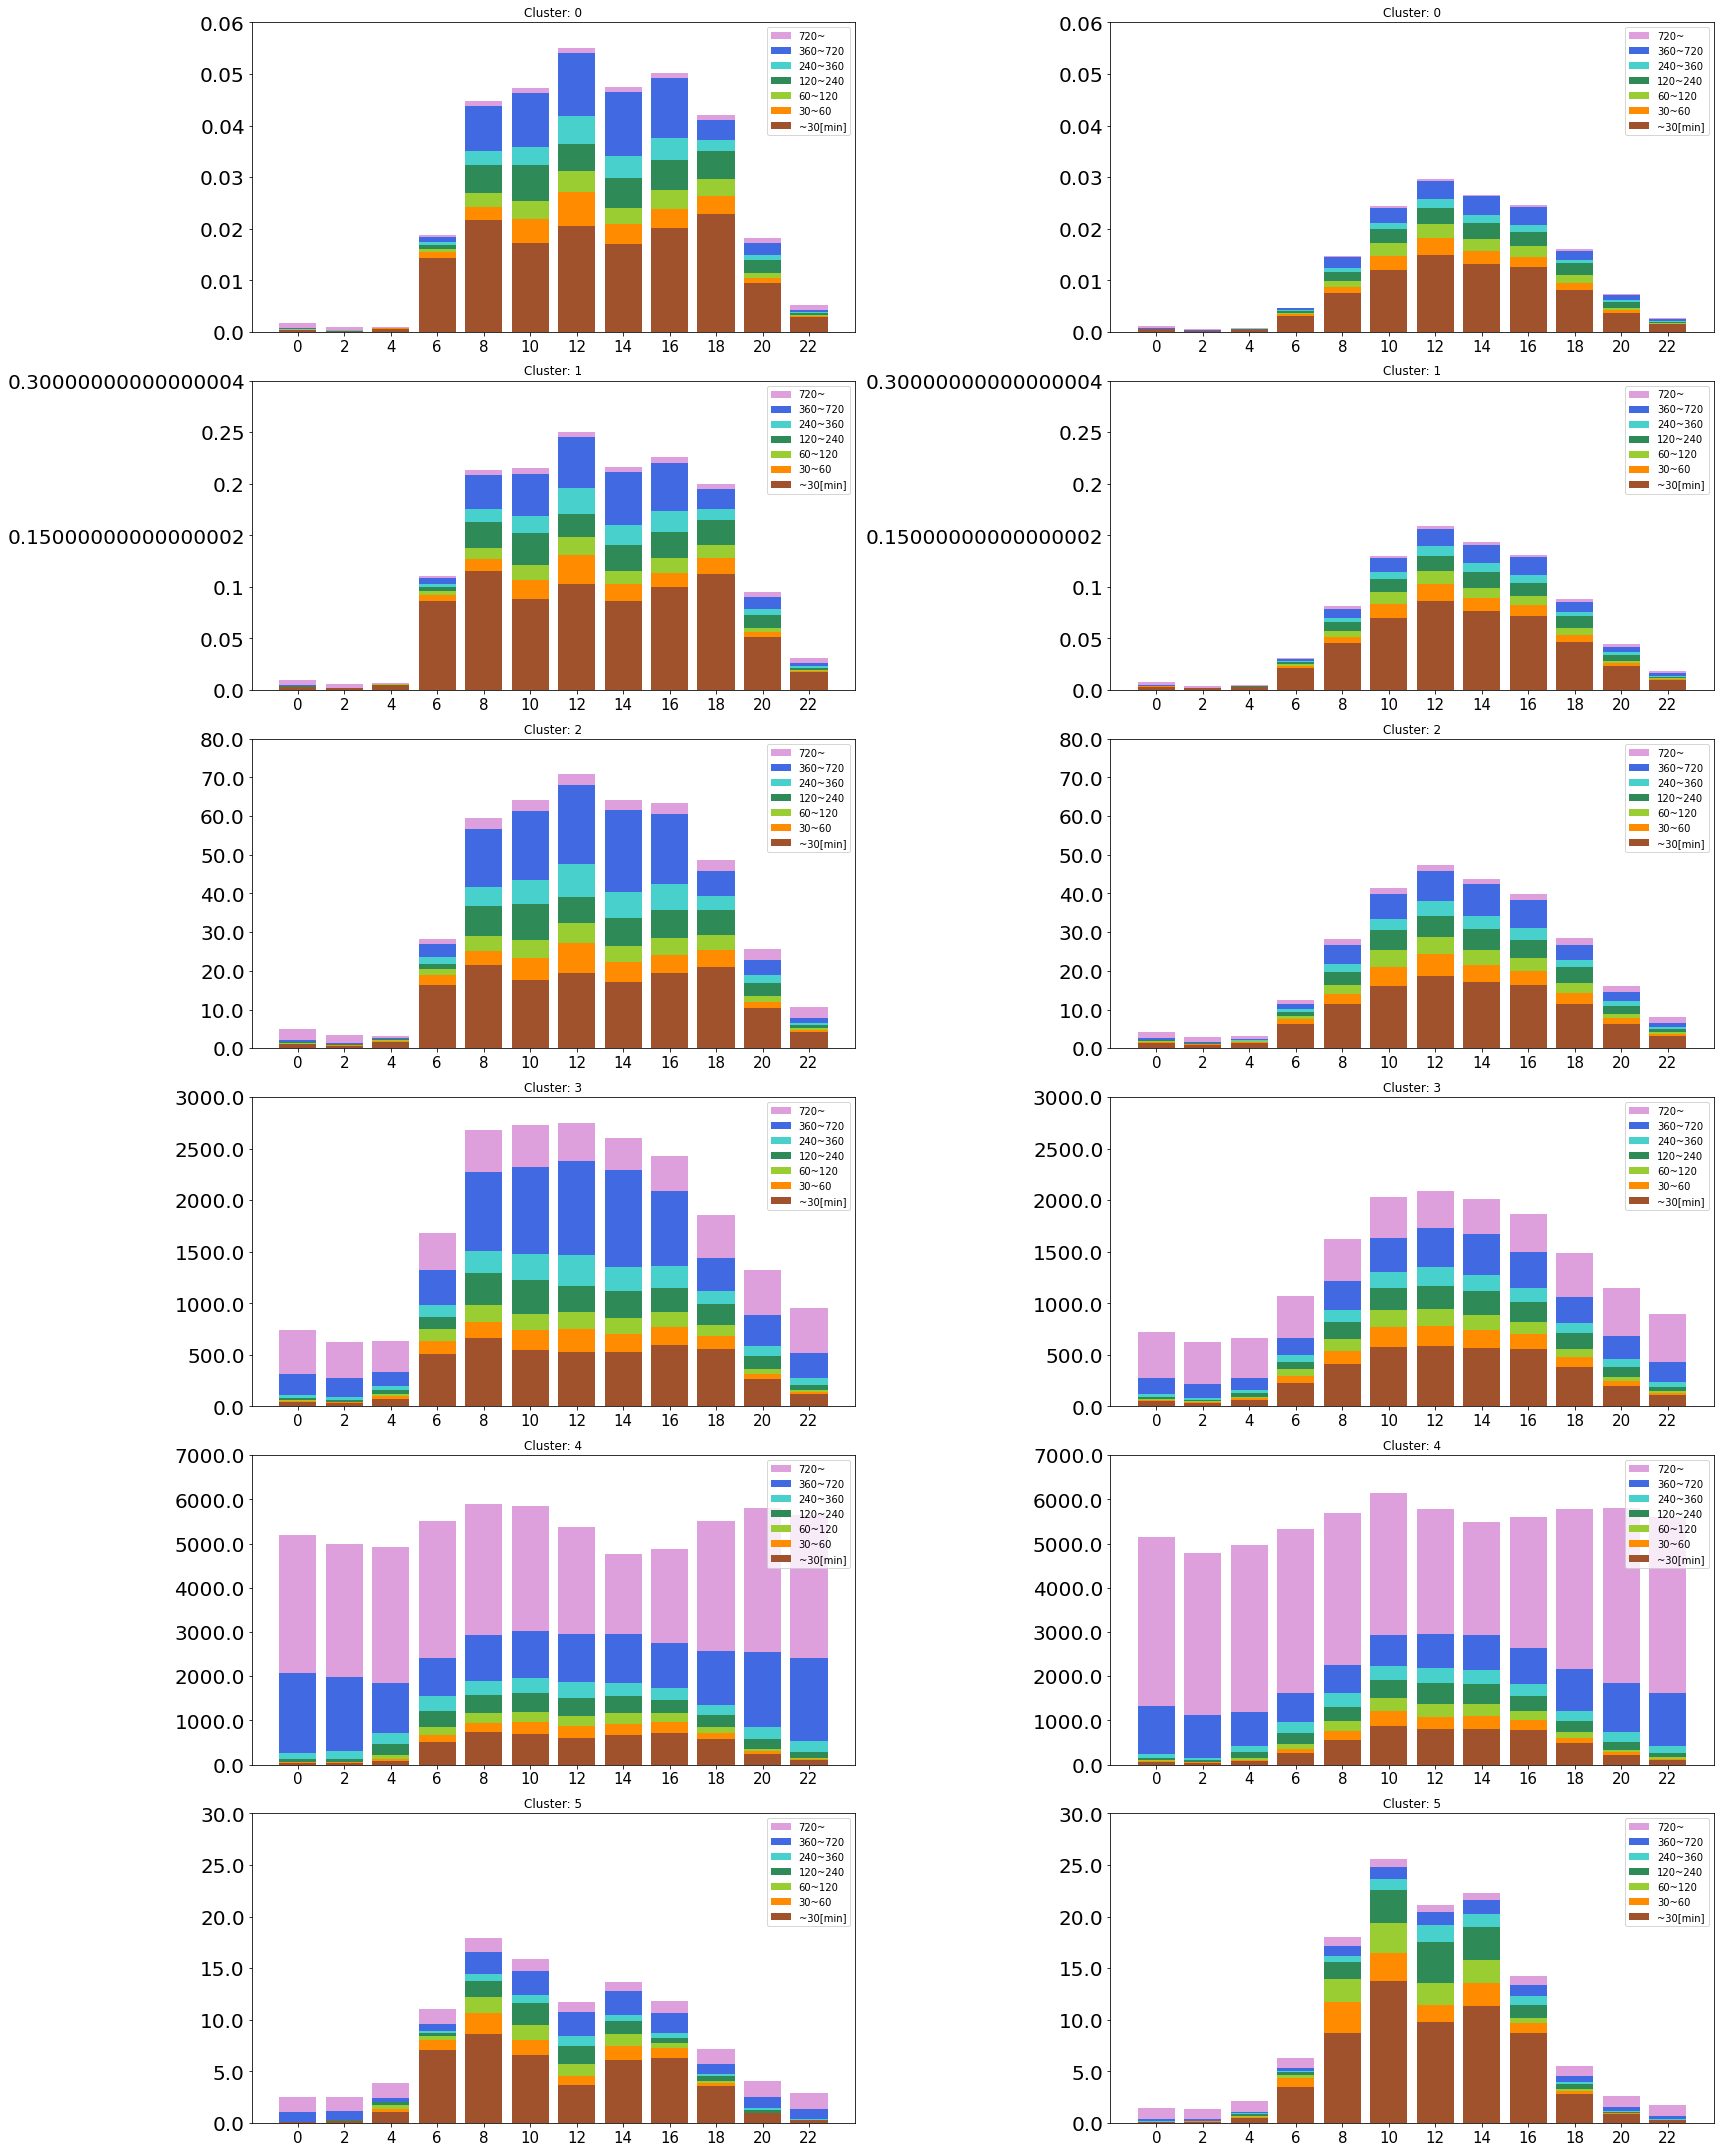

In [6]:
# Stacked graph(stay tendency)
visualizer.visualize(visualizer.elapsed_each_time_each_cluster, title="Elapsed")

## Geographial visualization of area similarity

In [7]:
for i in range(len(mesh_data["features"])):
    mesh_data["features"][i]["properties"]["distance"] = distances[i]
    mesh_data["features"][i]["properties"]["distance_cluster"] = result[i]

In [8]:
m = KeplerGl(height=800, width=1200, data={"cluster_map": mesh_data})
# m.config = config
# m.save_to_html(data={"cluster_map": mesh_data}, config=m.config, file_name="../data/japan_city/cluster_map/"+data_name+".html")
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'cluster_map': {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'typ…